# Feature Engineering, IWCD Short Tank Dataset

1. Beta Parameters (Isotropy)
2. Time of Flight
3. Vertex Opening Angle
4. Angular RMS (Consecutive Hits)
5. Distance to Tank Wall

Given features are: <br>
time, charge, x(PMT), y(PMT), z(PMT), xdir(PMT), ydir(PMT) and zdir(PMT) or: <br>
time, charge, hit PMT position (x, y, z), hit PMT orientation (x, y, z) <br><br>

These are all hit level features. There can be up to ~150 hits in an event. These hit level features are useful for models like graph networks, CNN, PointNet etc. but for a standard NN (MLP), training is best on global levels features for this dataset. <br><br>
In this notebook, several engineered features are introduced, mainly to capture the difference between the spatial hit distributions in neutron capture vs electron background events.

In [1]:
# import packages
import pandas as pd
import math
import numpy as np
import h5py
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [22]:
# file paths
h5_filepath = "/home/mattStubbs/watchmal/NeutronGNN/data/h5_files/iwcd_mpmt_shorttank_neutrongnn_6.h5"
train_indices_file = "/home/mattStubbs/watchmal/NeutronGNN/data/splits/train_indicies_6.txt"
val_indices_file = "/home/mattStubbs/watchmal/NeutronGNN/data/splits/validation_indicies_6.txt"
test_indices_file = "/home/mattStubbs/watchmal/NeutronGNN/data/splits/test_indicies_6.txt"

In [188]:
# import data
with h5py.File(h5_filepath, 'r') as file:
    print(list(file.keys()))
    h5_event_data = file['event_data']
    h5_nhits = file['nhits']
    h5_labels = file['labels']
    labels = np.array(h5_labels)
    
    event_data = np.memmap(h5_filepath, mode='c', shape=h5_event_data.shape,
                               offset=h5_event_data.id.get_offset(),
                               dtype=h5_event_data.dtype)
    print("{} events; up to {} hits per event; {} features per hit per event.".format(event_data.shape[0],
                                                                    event_data.shape[1], event_data.shape[2]))
    nhits = np.array(h5_nhits)
    positions0 = file['positions']
    positions0 = np.array(positions0)   #initial positions of simulated particles
    angles = file['angles']             #initial angles of simulated particles
    angles = np.array(angles)

['angles', 'energies', 'event_data', 'event_ids', 'labels', 'nhits', 'positions', 'root_files']
1574748 events; up to 300 hits per event; 8 features per hit per event.


In [155]:
# flatten event vertex array
npPositions0 = [positions0[i].flatten() for i in range(len(positions0))]

# 1. Beta Parameters (Isotropy)

Beta Parameters are one of the possible metrics that characterize event topology. Dunmore (Dunmore, Jessica A. (2004). The Separation of CC and NC Events in the Sudbury Neutrino Observatory) find the beta parameters to yield the most angular discrimination between particle events. Following their results (and others), the beta parameters were chosen as the isotropy parameter in this research. The l'th beta parameter is defined as follows:
<h2><center>$\beta_{l} = \langle P_{l} (\cos\theta_{ik}) \rangle _{i\neq k}$</center></h2>

where the l'th beta parameter is equal to the average of the l'th Legendre polynomial P$_{l}$ of the cosine of the angle $\theta_{ik}$ between every pair of hit PMTs in the event. A higher value indicates greater directionality.

The following is the basic code for calculating the beta parameters:

In [1]:
def calculateBeta(x):
    B1Sum = 0.0; B1ave = 0.0; B2Sum = 0.0; B2ave = 0.0; B3Sum = 0.0; B3ave = 0.0; B4Sum = 0.0; B4ave = 0.0; 
    B5Sum = 0.0; B5ave = 0.0; counter = 0.0; B14 = 0.0; 
    for i in range(nhits[x]):
        for j in range(nhits[x]):
            if i != j:
                B1Sum += Legendre(cosTheta(event_mem_data[x, i, 2:5], event_mem_data[x, j, 2:5], np.transpose(positions0[x])), 1)
                B2Sum += Legendre(cosTheta(event_mem_data[x, i, 2:5], event_mem_data[x, j, 2:5], np.transpose(positions0[x])), 2)
                B3Sum += Legendre(cosTheta(event_mem_data[x, i, 2:5], event_mem_data[x, j, 2:5], np.transpose(positions0[x])), 3)
                B4Sum += Legendre(cosTheta(event_mem_data[x, i, 2:5], event_mem_data[x, j, 2:5], np.transpose(positions0[x])), 4)
                B5Sum += Legendre(cosTheta(event_mem_data[x, i, 2:5], event_mem_data[x, j, 2:5], np.transpose(positions0[x])), 5)
                counter += 1.0

    B1ave = B1Sum / counter
    B2ave = B2Sum / counter
    B3ave = B3Sum / counter
    B4ave = B4Sum / counter
    B5ave = B5Sum / counter
    return B1ave, B2ave, B3ave, B4ave, B5ave

In practice, due to the long calculation time, multiprocessing is applied to calculate beta parameters for multiple events in parallel. Several batch script are submitted for different subsets of the data to further reduce overall computation time. Overall, the full 1.8 million events are processed in under 24 hours.

Read in the full, event index sorted file of beta parameters:

In [4]:
betas = np.genfromtxt('/home/mattStubbs/watchmal/NeutronGNN/Kore/Isotropy/betasALL/betas_sorted_all.csv', delimiter=',')

__view electron/neutron beta separation__

In [11]:
neutron_betas=[]
electron_betas=[]
for x in betas:    
    if labels[int(x[0])] == 0:   #neutron
        neutron_betas.append(x)
    elif labels[int(x[0])] == 1:   #electron
        electron_betas.append(x)

In [17]:
neutron_betas = np.array(neutron_betas)
electron_betas = np.array(electron_betas)
print("{} neutron events, {} beta parameters per event".format(
    neutron_betas.shape[0], neutron_betas.shape[1]-1))
print("{} electron events, {} beta parameters per event".format(
    electron_betas.shape[0], electron_betas.shape[1]-1))

834171 neutron events, 5 beta parameters per event
925789 electron events, 5 beta parameters per event


In [19]:
non_zero = [np.count_nonzero(event_data[i,:,0]) for i in range(0, event_data.shape[0])]
non_zero  = np.array(non_zero)
assert nhits.all() == non_zero.all()

Text(0.5, 0.98, 'Beta Isotropy Parameters, IWCD Short Tank')

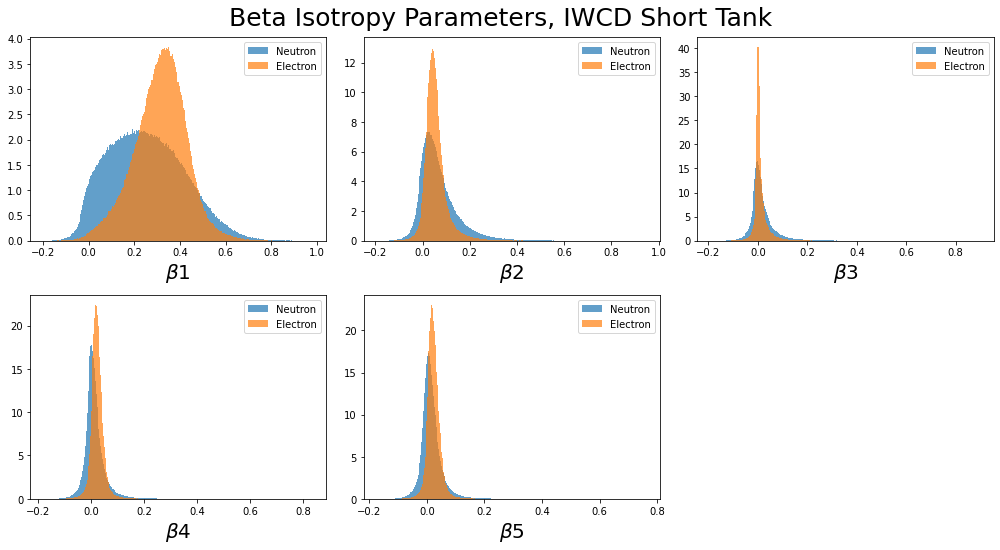

In [23]:
fig = plt.gcf()
fig.set_size_inches(14, 8)

for idx in range(5):
    ax = fig.add_subplot(2, 3, idx+1)
    res = plt.hist(neutron_betas[:, idx+1], bins=300, alpha=0.7, density=True, label = "Neutron")
    res = plt.hist(electron_betas[:, idx+1],  bins=300, alpha=0.7, density=True, label = "Electron")
    plt.xlabel(r'$\beta$' + str(idx+1), fontsize=20)
    plt.legend()

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Beta Isotropy Parameters, IWCD Short Tank', fontsize=25)
#plt.savefig("betas.png", dpi=600, bbox_inches='tight') 
#r'$\beta_1 + 4 * \beta_4$'

we can also look at the correlations between the beta parameters through scatterplots

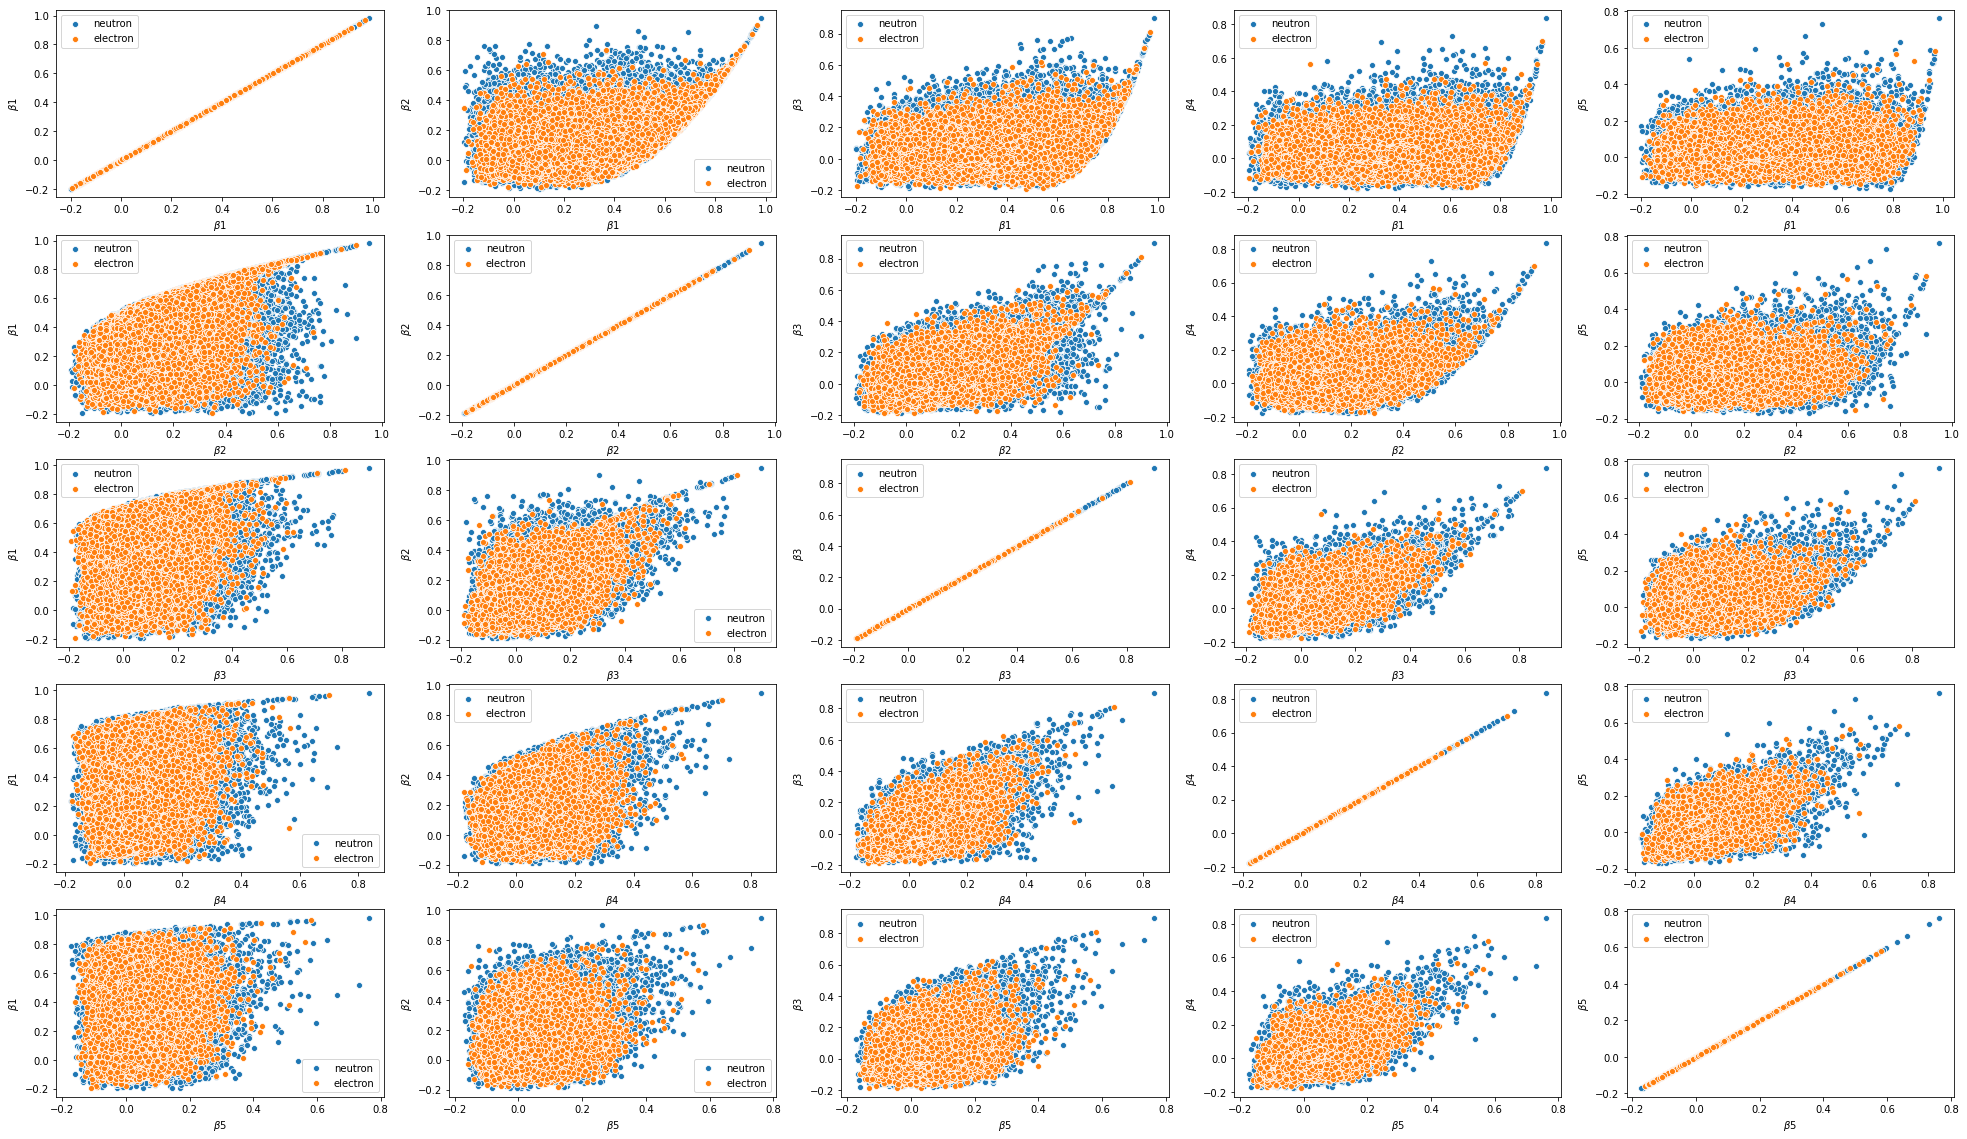

In [31]:
fig = plt.gcf()
fig.set_size_inches(34, 20)

for i in range(5):
    for j in range(5):
        ax = fig.add_subplot(5, 5, i*5 + j + 1)
        #if i != j:
            #ax = fig.add_subplot(5, 4, i*5 + j + 1)
        sns.scatterplot(neutron_betas[:, i+1], neutron_betas[:, j+1], label = "neutron")
        sns.scatterplot(electron_betas[:, i+1], electron_betas[:, j+1], label = "electron")
        plt.xlabel(r'$\beta$' + str(i+1))
        plt.ylabel(r'$\beta$' + str(j+1))
    ax.set_title("")
    plt.legend()

#plt.savefig("scatterplots.png", bbox_inches='tight')

# Time of Flight

Separate neutron and electron events, capture respective timing info

In [8]:
neutron_times = []
electron_times = []

for x in range(event_data.shape[0]):
    if labels[x] == 0:    #neutron
        neutron_times.append(event_data[x][:, 1])
    elif labels[x] == 1:   #electron
        electron_times.append(event_data[x][:, 1])
    else:
        pass

In [14]:
# sample times
print('neutron example event timing: {}'.format(
    neutron_times[0][:np.count_nonzero(neutron_times[0])]))
print('\nelectron example event timing: {}'.format(
    electron_times[0][:np.count_nonzero(electron_times[0])]))

neutron example event timing: [ 967.7012   973.8008   954.8008   997.2012   953.9004   953.
  988.2012   962.10156  982.2012   984.8008   952.7012   955.60156
  975.3008   980.3008   972.3008   954.       956.60156  956.8008
  953.8008   953.4004   737.2012  1864.4004 ]

electron example event timing: [ 952.   960.3  948.8  945.8  943.5  965.4  944.8  932.3 1821.4]


In [15]:
print("number of neutron events: {}".format(len(neutron_times)))
print("number of electron events: {}".format(len(electron_times)))

number of neutron events: 2484
number of electron events: 2754


Overall event flight times (susceptible to dark noise):

In [17]:
nft = []
eft = []
for i in range(len(neutron_times)):
    nft.append(np.max(neutron_times[i])-np.min(neutron_times[i][np.nonzero(neutron_times[i])]))
for i in range(len(electron_times)):
    eft.append(np.max(electron_times[i]) - np.min(electron_times[i][np.nonzero(electron_times[i])]))

In [19]:
print(eft[0])

889.10004


In [20]:
# sample times
print('neutron flight times sample: {}'.format(
    nft[:15]))
print('\nelectron flight times sample: {}'.format(
    eft[:15]))

neutron flight times sample: [1127.1992, 1251.1992, 386.69995, 116.1001, 376.30078, 792.2031, 417.10156, 33.399902, 59.899414, 651.2969, 793.2002, 931.10156, 1065.0996, 167.39844, 26.90039]

electron flight times sample: [889.10004, 269.99994, 422.3, 174.60004, 66.29999, 991.80005, 686.8999, 855.2001, 85.80005, 611.69995, 49.799988, 60.299988, 53.5, 117.00006, 464.09998]


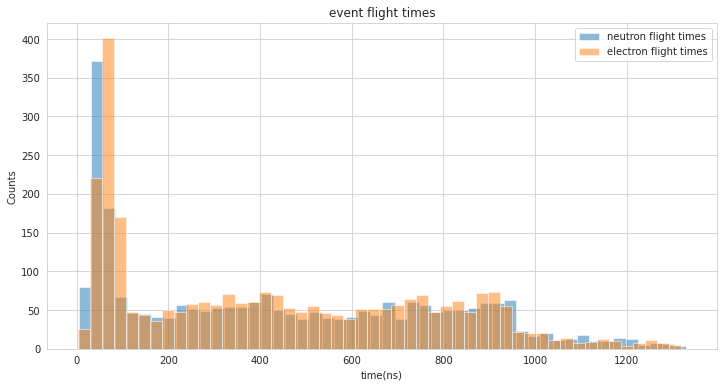

In [25]:
sns.set_style('whitegrid')
plt.figure(figsize = (12,6))
plt.hist(nft, alpha=0.5, bins=50, label = 'neutron flight times')
plt.hist(eft, alpha=0.5, bins=50, label = 'electron flight times')
plt.xlabel('time(ns)'); plt.title("event flight times")
plt.ylabel('Counts')
plt.legend()

1. From the above, we can see more neutron events with shorter overall flight times. This makes sense given neutron events have fewer hits on average. <br>
2. However, overall flight time is a bit of a naive measure given that any dark noise hits before or after the event will greatly skew the metric from the truth. <br>
3. For this reason, we can look instead toward the mean and RMS flight time.

__RMS Flight Time__

In [26]:
ntofRMS = []
etofRMS = []

In [29]:
ntofRMS = []
etofRMS = []
for i in range(len(neutron_times)):
    if i%50000==0: # progress update on long datasets
        print('event {}'.format(i))
    countI = np.count_nonzero(neutron_times[i]) # count nonzero hits
    meanI = np.mean(neutron_times[i][:countI])  # compute mean
    # calculate RMS per event as sqrt((sum(hitTime-mean_hitTime)^2)/count)
    ntofRMS.append(math.sqrt(np.sum((neutron_times[i]-meanI)[:countI]**2) / countI))
    
for i in range(len(electron_times)):
    if i%50000==0: # progress update on long datasets
        print('event {}'.format(i))
    countI = np.count_nonzero(electron_times[i])
    meanI = np.mean(electron_times[i][:countI])
    etofRMS.append(math.sqrt(np.sum((electron_times[i]-meanI)[:countI]**2) / countI))

event 0
event 0


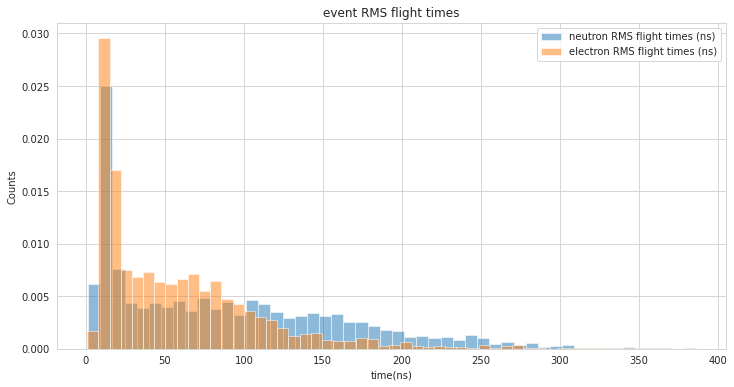

In [32]:
sns.set_style('whitegrid')
plt.figure(figsize = (12,6))
plt.hist(ntofRMS, alpha=0.5, bins=50, density=True, label = 'neutron RMS flight times (ns)')
plt.hist(etofRMS, alpha=0.5, bins=50, density=True, label = 'electron RMS flight times (ns)')
plt.xlabel('time(ns)'); plt.title("event RMS flight times")
plt.ylabel('Counts')
plt.legend()

The above shows a different pattern than overall event flight times.
1. The neutron RMS time distribution indicates that on average, more neutron events have hits which deviate further from the mean hit time than for electron background.
2. This could be due to the nature of neutron capture, whereupon after the capture occurs, a photon is emitted which usually emits a pair of electrons (in our energy regime, capture on Gadolinium). This pair production could be registered on different ends of the tank, leading to longer hit PMT times. However, if the emitted photon energy is low enough, the photon could undergo Compton scattering or the photoelectric effect, after which there will only be one electron registering Cherenkov radiation. This will lead to a shorter event time. This variability is represented by the short and long tails of the neutron event RMS distribution.
3. RMS hit time is also less susceptible to dark noise hits. Any hits before or after the true event will be considered as one factor amongst all hits in the RMS calculation and not skew the metric significantly.

__mean flight time__

In [33]:
ntofMean = []
etofMean = []
for i in range(len(neutron_times)):
    countI = np.count_nonzero(neutron_times[i])
    meanI = np.mean(neutron_times[i][:countI])
    ntofMean.append(meanI)
for i in range(len(electron_times)):
    countI = np.count_nonzero(electron_times[i])
    meanI = np.mean(electron_times[i][:countI])
    etofMean.append(meanI)

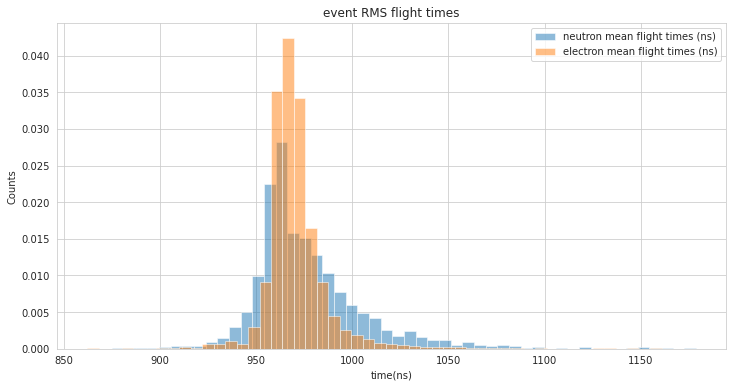

In [34]:
sns.set_style('whitegrid')
plt.figure(figsize = (12,6))
plt.hist(ntofMean, alpha=0.5, bins=50, density=True, label = 'neutron mean flight times (ns)')
plt.hist(etofMean, alpha=0.5, bins=50, density=True, label = 'electron mean flight times (ns)')
plt.xlabel('time(ns)'); plt.title("event mean flight times")
plt.ylabel('Counts')
plt.legend()

Observations from the above plot:
1. The shape of this distribution is not surprising. We expect a wider distribution of mean times for neutron events due to reasons listed above (for RMS times). We see a greater number of electron events with a mean time around 960-980ns than for neutron captures.
2. This distribution, although shifted from RMS times, is similar. Likely this indicates the inclusion of both RMS times and Mean times in a standard NN will not significantly improve performance beyond the inclusion of either.

# Vertex Opening Angle

Cherenkov photons from relativistic particles are emitted on a cone with an opening angle from the direction of the incident particle given by the Cherenkov radiation equation. The peak opening angle is, among other things, a function of the energy of the incident particle. Therefore, there should be a difference in the peak opening angle for the neutron capture distribution vs the electron background Cherenkov distribution. 

__Mean Opening Angle__

First, let us define some helper functions

In [8]:
def mag(v):
    return np.linalg.norm(v)
    
def cosTheta(v, orig):
    return np.dot(v, orig) / (mag(v) * mag(orig))

In [9]:
def theta(v, orig):
    cosT = cosTheta(v,orig)
    if abs(cosT) >= 1.00:  # if cos lies in the defined range
        return np.nan
    else:
        return math.acos(cosT) * (180/math.pi)

The mean opening angle is computed by calculating the average of the vector sum of the angles between every hit with respect to the event vertex. 

In [10]:
def mean_opening_angle(event):
    angle = []
    orig = npPositions0[event]
    for hit in range(nhits[event]):
        v = np.array([event_data[event,hit,2], event_data[event,hit,3],
                      event_data[event,hit,4]])
        angle.append(theta(v, orig))          
    return np.nanmean(angle)

In [51]:
neutron_moa = []
electron_moa = []
for x in range(event_data.shape[0]):
    if(x)%35000==0: # progress update for large datasets
        print("event {}".format(x))
    if labels[x]==0:
        neutron_moa.append(mean_opening_angle(x)) 
    elif labels[x]==1:
        electron_moa.append(mean_opening_angle(x)) 

event 0
event 35000


In [52]:
# convert to numpy arrays, print statistics
neutron_moa = np.array(neutron_moa)
electron_moa = np.array(electron_moa)
print('neutron mean opening angle stats: {}'.format(stats.describe(neutron_moa)))
print('\nelectron mean opening angle stats: {}'.format(stats.describe(electron_moa)))

neutron mean opening angle stats: DescribeResult(nobs=20779, minmax=(3.5416814988147896, 135.69243423183977), mean=61.73933261637964, variance=400.8496532739609, skewness=0.2881119657163599, kurtosis=-0.3106236844597903)

electron mean opening angle stats: DescribeResult(nobs=23182, minmax=(4.907890631569312, 133.78389053577757), mean=60.58196806727553, variance=443.81665915662376, skewness=0.2840865335248115, kurtosis=-0.6473251827964832)


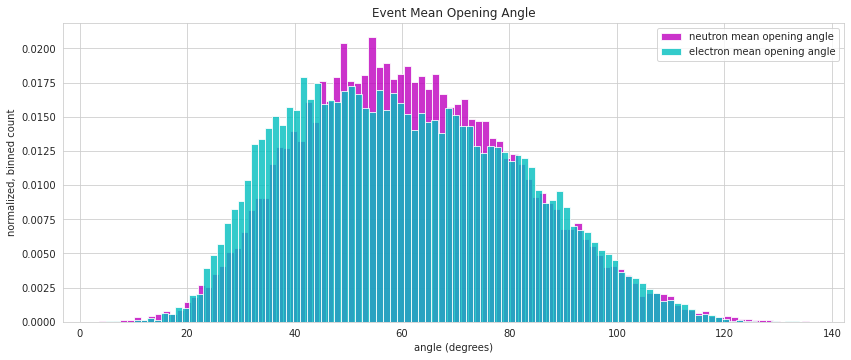

In [59]:
fig = plt.figure(figsize=(14,5.5))
nMOA = plt.hist(neutron_moa, color='m', bins=100, density = True, alpha=0.8, label='neutron mean opening angle')
eMOA = plt.hist(electron_moa, color='c', bins=100, density = True, alpha=0.8, label='electron mean opening angle')
plt.xlabel('angle (degrees)')
plt.ylabel('normalized, binned count')
plt.title('Event Mean Opening Angle')
plt.legend()
#plt.savefig('mean opening angle', bbox_inches='tight', dpi=600 )

Observations from the above plot:
1. As expected, there is a difference in the peak of the mean opening angle for these two particle type events. The electron peak is at a smaller angle (60.58) to the neutron capture peak (61.74), although these numbers are similar. This could be caused by the fact that the two distributions were generated with a very similar energy range.
2. Note that a smoother distribution occurs when the full dataset (~1.8 million events) is included. The overall shape remains similar, the effect of more data is just to smooth it out.

__RMS Opening Angle__

The RMS opening angle might provide another perspective on the opening angle discrimination

In [ ]:
def rms_opening_angle(event):
    angle = []
    rmsAng = []
    orig = npPositions0[event]
    countI = np.count_nonzero(event_data[event,:,1])
    
    for hit in range(nhits[event]):
        v = np.array([event_data[event,hit,2], event_data[event,hit,3],
                      event_data[event,hit,4]])
        angle.append(theta(v, orig))
                
    meanAng = np.nanmean(angle)
    
    return math.sqrt(np.sum((angle-meanAng)**2)/countI)

In [62]:
neutron_rms_ang = []
electron_rms_ang = []
for x in range(event_data.shape[0]):
    if(x)%35000==0:
        print(x)
    if labels[x]==0:
        neutron_rms_ang.append(rms_opening_angle(x)) 
    elif labels[x]==1:
        electron_rms_ang.append(rms_opening_angle(x)) 

0
35000


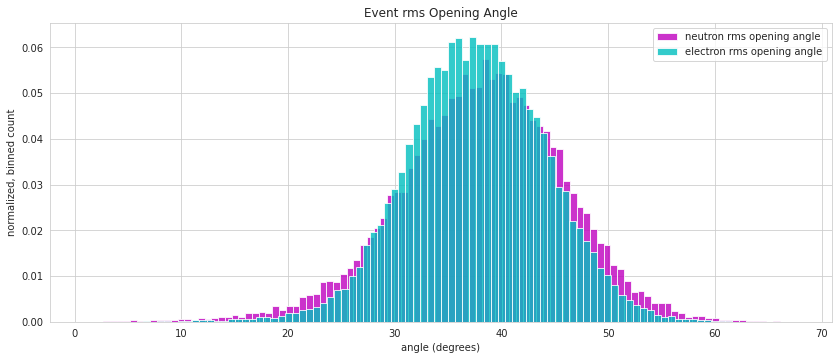

In [68]:
fig = plt.figure(figsize=(14,5.5))
neutron_ang_rms = plt.hist(neutron_rms_ang, color='m', bins=100, density = True, alpha=0.8, label='neutron rms opening angle')
electron_ang_rms = plt.hist(electron_rms_ang, color='c', bins=100, density = True, alpha=0.8, label='electron rms opening angle')
plt.xlabel('angle (degrees)')
plt.ylabel('normalized, binned count')
plt.title('Event rms Opening Angle')
plt.legend()
#plt.savefig('mean opening angle', bbox_inches='tight', dpi=600 )

Again, the RMS plot is generally similar to the mean plot. However, there are some differences:
1. The neutron events have more counts at the tails (lower/higher angles). This is explicable from the same pair production vs scattering argument as with RMS flight times. 
2. The electron RMS times have a narrower distribution, peaking at a lower RMS angle than neutron events. Since the background electron radiation has a single production mechanism, with a fairly uniform spatial distribution pattern throughout the tank, it makes sense for the opening angle residuals to be more evenly distributed.

# Angular RMS 

Angular RMS Metric: for every event, compute array of angles between consecutive hits (time sorted) wrt vertex -> the RMS angle is the RMS of these consecutive hit angular differences.
<br>

Intuition: <br>
signal: RMS angle should be small as steps between consecutive hits should be similar
background: RMS should be larger. Small steps within clusters, then large steps between clusters

Essentially the angular RMS should be larger for background events with more spatial clustering, and smaller for signal events where the spatial distribution throughout the tank is more uniform.

* note: for electron background/ neutron signal dataset, this difference will be less pronounced as electron dataset has a more uniform spatial distribution than true dark noise background. In fact, due to pair production from neutron captures, the angular RMS might actually have peak at a larger angles than the background electron distribution.

__time sorting__

In [70]:
def sortTimeAsc(x):
    temp = event_data[x][np.argsort(event_data[x][:nhits[x], 1])]
    event_data[x] = np.append(temp, np.zeros((300-nhits[x], 8)), axis = 0)

In [72]:
for i in range(event_data.shape[0]):
    sortTimeAsc(i)

In [73]:
# test events are time sorted
for i in range(3):
    print(event_data[i][:, 1][:nhits[i]])

[ 950.   950.5  951.   951.1  951.6  952.   952.7  953.   953.1  953.2
  953.5  954.3  954.4  954.4  955.4  955.6  955.8  956.5  956.6  956.9
  957.7  958.5  958.9  958.9  959.3  959.5  959.5  960.9  961.4  962.6
  962.7  963.   963.7  966.2  966.7  968.7  968.8  971.4  971.8  972.8
  972.8  972.8  973.   973.   973.   973.3  973.4  973.4  973.4  974.1
  974.7  974.7  975.   975.8  975.8  976.9  978.9  981.7  983.3  983.5
  984.2  984.3  984.3  984.9  987.   988.3  989.2 1001.8 1002.1 1003.1
 1024.5]
[947.3 947.9 949.1 949.1 949.1 950.  951.3 951.9 952.  952.6 952.8 953.7
 953.7 953.9 954.4 954.5 955.  956.8 957.2 957.6 958.4 959.9 960.2 960.6
 964.  965.8 969.5 971.7 971.7 974.  974.1 976.3 980.8 981.7 983.  985.6
 989.2]
[ 951.3  951.9  951.9  952.4  952.5  953.   953.4  953.5  953.6  953.9
  954.3  955.4  955.7  955.8  956.4  957.4  957.5  957.7  959.   960.6
  963.1  964.   966.5  966.6  967.6  971.8  973.8  973.8  977.2  978.1
  979.7  980.8  980.8  980.9  981.2  981.6  982.   982

In [74]:
# consecutive angle function, append angles between consecutive hits wrt ev vertex
def cons_angle_RMS(i):
    angle_list=[]
    countI = np.count_nonzero(event_data[i,:,1])
    for hit in range(nhits[i]-1):
        angle_list.append(theta(event_data[i,hit,2:5], event_data[i,hit+1,2:5]))
    
    angle_list = np.array(angle_list)
    mean_ang = np.nanmean(angle_list)
    
    return math.sqrt(np.sum((angle_list-mean_ang)**2)/countI)

In [75]:
n_rms_consAngle = []
e_rms_consAngle = []

for x in range(event_data.shape[0]):
    if x%50000==0:
        print('event: {}'.format(x))
    if labels[x]==0:
        n_rms_consAngle.append(cons_angle_RMS(x)) 
    elif labels[x]==1:
        e_rms_consAngle.append(cons_angle_RMS(x)) 

event: 0


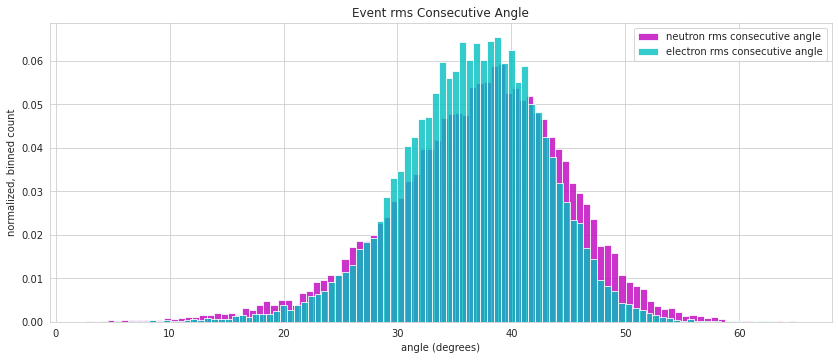

In [76]:
fig = plt.figure(figsize=(14,5.5))
nMOA = plt.hist(n_rms_consAngle, color='m', density = True, bins=100, alpha=0.8, label='neutron rms consecutive angle')
eMOA = plt.hist(e_rms_consAngle, color='c', density = True, bins=100, alpha=0.8, label='electron rms consecutive angle')
plt.xlabel('angle (degrees)')
plt.ylabel('normalized, binned count')
plt.title('Event rms Consecutive Angle')
plt.legend()


Notes from above plot:
1. Both electron background and neutron captures were generated as fairly spatially uniform distributions. On top of this, neutron captures often lead to pair producing gammas in our energy range, which could cause successive hit angles to fluctuate more widely. 
2. Thus, it is not unexpected that the neutron capture angular RMS would peak at a higher angle. However, we would expect a true dark noise background distribution to peak at a significantly still higher angle.

# Distance to Wall

The distance from event vertex to detector wall is another potential event discriminator, given that many background events tend to occur due to radioactive process that originate near the walls of the detector.

* note: again, keep in mind that the electron dataset we are working with is not true background, more of a spatially uniform energy distribution. We might still expect some discrimination, but this effect should be much more pronounced on true background datasets significantly impacted by dark noise.

__computational note__
minimum distance can be computed in multiple ways:
1. polar coordinate approach
2. geometry approach: radius - minimum distance from vertex to line from bottom to top of detector
The geometry approach is shown here (perhaps a bit more involved)

In [146]:
# minimum distance to wall along the lateral side
def distWallLateral(x):
    B = np.array([0, -300, 0])     # bottom middle of tank
    C = np.array([0, 300, 0])      # top middle of tank 
    A = npPositions0[x]            # vertex of event
    rad = 400                      # radius of tank

    d = (C - B) / np.linalg.norm(C - B)     # direction vector from bottom to top of tank
    v = A - B                               # vector from bottom of tank to point in the tank
    t = np.dot(v, d)                        # projection scalar of point on the line from bottom to top of tank

    P = B + t * d                  
    # point on line from bottom to top of cylinder closest to the point A in the cylinder

    distP = np.linalg.norm(P - A)           
    # distance from point in cylinder to closest point on axial line
    distWall = rad - distP  
    return distWall

In [147]:
# test function for a few events
for i in range(3):
    print(distWallLateral(i))

315.2064391799032
312.35861459522374
45.350886262537244


In [99]:
# compute variables for a few events manually for plotting demo
B = np.array([0, 300, 0])       # bottom middle of tank
C = np.array([0, -300, 0])      # top middle of tank 
A0 = npPositions0[0]            # vertex of first event
A1 = npPositions0[1]
A2 = npPositions0[2]
rad = 400                       # radius of tank

d = (C - B) / np.linalg.norm(C - B)       # direction vector from bottom to top of tank
v0 = A0 - B                               # vector from bottom of tank to point in the tank
v1 = A1 - B 
v2 = A2 - B 

t0 = np.dot(v0, d)                        # projection scalar of point on the line from bottom to top of tank
t1 = np.dot(v1, d)
t2 = np.dot(v2, d)

P0 = B + t0 * d                  # point on line from bottom to top of cylinder closest to the point A in the cylinder
P1 = B + t1 * d 
P2 = B + t2 * d 

distP0 = np.linalg.norm(P0 - A0)          # distance from point in cylinder to closest point on line from bottom to top of tank (middle axis)
distP1 = np.linalg.norm(P1 - A1)
distP2 = np.linalg.norm(P2 - A2)

distWall0 = rad - distP0         # shortest distance to the wall of the tank along the lateral side
distWall1 = rad - distP1
distWall2 = rad - distP2

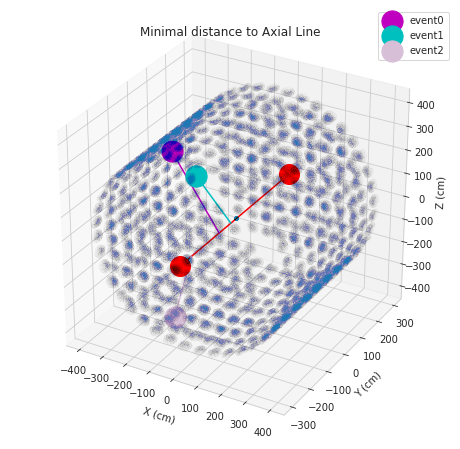

In [107]:
npPositions0 = np.array(npPositions0)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    xs=event_data[:, :, 2],
    ys=event_data[:, :, 3],
    zs=event_data[:, :, 4],
    alpha = 0.003,
)
#ax.set_title('Hit Locations of 16,000 events')
ax.set_title('Minimal distance to Axial Line')
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Z (cm)')

#a, b = [0,-300,0], [0, 300, 0]
x0, y0, z0 = [0, 0], [-300, 300], [0, 0]
paX, paY, paZ = [P0[0], npPositions0[0, 0]], [P0[1], npPositions0[0, 1]], [P0[2], npPositions0[0, 2]]
paX1, paY1, paZ1 = [P1[0], npPositions0[1, 0]], [P1[1], npPositions0[1, 1]], [P1[2], npPositions0[1, 2]]
paX2, paY2, paZ2 = [P2[0], npPositions0[2, 0]], [P2[1], npPositions0[2, 1]], [P2[2], npPositions0[2, 2]]


ax.scatter(xs=0, ys=-300, zs=0, s = 400, color = 'red')
ax.scatter(xs=0, ys=300, zs=0, s = 400, color = 'red')

ax.scatter(xs=npPositions0[0, 0], ys = npPositions0[0, 1], zs = npPositions0[0, 2], s=450, color='m', label='event0')
ax.scatter(xs=npPositions0[1, 0], ys = npPositions0[1, 1], zs = npPositions0[1, 2], s=450, color='c', label='event1')
ax.scatter(xs=npPositions0[2, 0], ys = npPositions0[2, 1], zs = npPositions0[2, 2], s=450, color='thistle', label='event2')

ax.plot(x0, y0, z0, color='r')
ax.plot(paX, paY, paZ, color='m')
ax.plot(paX1, paY1, paZ1, color='c')
ax.plot(paX2, paY2, paZ2, color='thistle')
ax.legend()

plt.show()

The figure above demonstrates the geometry for a few events. The red points are the bottom and top middle of the water short tank, and the red line connects these points. The event vertices are marked by the label colours, and their respective coloured lines represent the minimum distance from vertex to axial tank line. Subtracting this distance from the tank radius yields the overall minimum distance to lateral cylinder wall.
<br>

Beside the lateral wall, the minimum distance could also be withrespect to the bottom or top endcap in the tank. This is accounted for in the following function.

In [227]:
def distance_to_wall(event):
    """return nearest part of detector wall to event vertex,
    and minimum distance to this location """
    
    distTopDisc = 300 - npPositions0[event][1]        # top_ring_y    -  vertex_y 
    distBottomDisc = npPositions0[event][1] + 300     # bottom_ring_y -  vertex_y 
    distWall = distWallLateral(event)                     # distance to lateral wall
    
    dist = {"Wall": distWall, "BottomDisc": distBottomDisc, "TopDisc": distTopDisc}
    nearest = min(dist, key=dist.get)
    
    return nearest, dist[nearest]
    #return locations[nearest]

In [228]:
# few examples, compare with above plots, does indeed make sense
for x in range(1300000,1300005):
    print(distance_to_wall(x))

('BottomDisc', 300.0)
('BottomDisc', 300.0)
('BottomDisc', 300.0)
('BottomDisc', 300.0)
('BottomDisc', 300.0)


In [236]:
print(npPositions0[1400000:1400010])

[array([0., 0., 0.], dtype=float32), array([0., 0., 0.], dtype=float32), array([0., 0., 0.], dtype=float32), array([0., 0., 0.], dtype=float32), array([0., 0., 0.], dtype=float32), array([0., 0., 0.], dtype=float32), array([0., 0., 0.], dtype=float32), array([0., 0., 0.], dtype=float32), array([0., 0., 0.], dtype=float32), array([0., 0., 0.], dtype=float32)]


In [120]:
# create array of distances
wallDist = []
for x in range(event_data.shape[0]):
    wallDist.append(distance_to_wall(x)[1])

In [121]:
wallDist = np.array(wallDist)

In [123]:
# separation of electron and neutron distances
neutron_wall_dist=[]
electron_wall_dist=[]
for x in range(event_data.shape[0]):
    if labels[x]==0:
        neutron_wall_dist.append(distance_to_wall(x)[1]) 
    elif labels[x]==1:
        electron_wall_dist.append(distance_to_wall(x)[1]) 
# convert to numpy arrays
neutron_wall_dist = np.array(neutron_wall_dist)
electron_wall_dist = np.array(electron_wall_dist)

In [126]:
# statistical descriptor
print('Neutron DWall Stats: {}'.format(stats.describe(neutron_wall_dist)))
print("\nElectron DWall Stats: {}".format(stats.describe(electron_wall_dist)))

Neutron DWall Stats: DescribeResult(nobs=20779, minmax=(0.009876119384216508, 299.2362141609192), mean=96.13109987025167, variance=4513.518285568612, skewness=0.7254119680329097, kurtosis=-0.2176947362527728)

Electron DWall Stats: DescribeResult(nobs=23182, minmax=(0.01778082798921332, 299.62756633758545), mean=90.93291878318779, variance=4585.707173096824, skewness=0.8026945581898459, kurtosis=-0.10181409017640686)


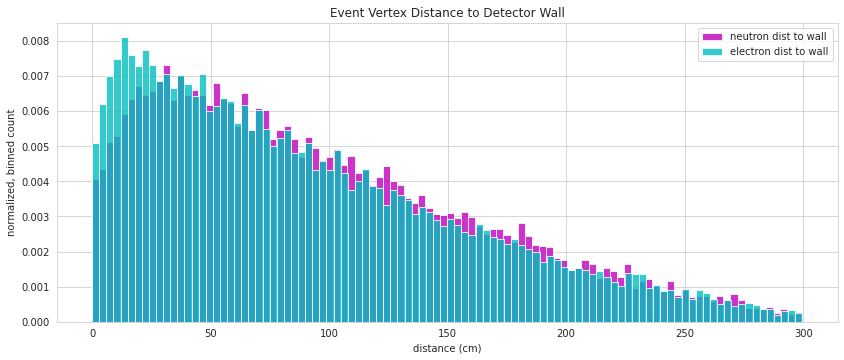

In [129]:
fig = plt.figure(figsize=(14,5.5))
nWallDist = plt.hist(neutron_wall_dist, bins=100, color='m', density = True, alpha=0.8, label='neutron dist to wall')
eWallDist = plt.hist(electron_wall_dist, bins=100, color='c', density = True, alpha=0.8, label='electron dist to wall')
plt.xlabel('distance (cm)')
plt.ylabel('normalized, binned count')
plt.title('Event Vertex Distance to Detector Wall')
plt.legend()
plt.savefig("dWall.png", dpi=600, bbox_inches='tight') 
#print(histogram_intersection(nWallDist, eWallDist, bins=20))